<a href="https://colab.research.google.com/github/casaArseniy/OS_CMR-SS-SAX-NN-HEALTHY-VS-ICMP/blob/main/ML_VideoMaskClass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OS-CMR SAX Single Slice

*   HEALTHY VS ICMP
*   3D CNN neural network
*   60/20/20 split (training/validation/testing) => 72/24/24 cases each

## SINGLE RUN
*   10 epochs
*   Batch size 8
*   Training data is augmented
*   Testing accuracy is 95.8%

## CROSS VALIDATION
*   30 epochs
*   Batch size 16
*   Average Testing accuracy is 99% !!!!








# Testing Initial Image Data (Mask x Image)

### Looking at the images of the sequences and checking whether I can extract only the LV using the masks.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import PIL.Image

In [ ]:
mask_directory = "/content/drive/MyDrive/CMR Thesis/Healthy_final/BIO0410005/RUN_2024-02-22T11-53-47/Post-HV_Breath-Hold/MaskData/MyocardiumMasks/"
mask_files = os.listdir(mask_directory)
mask_files = [mask_directory+file for file in mask_files if os.path.isfile(os.path.join(mask_directory, file))]

image_directory = "/content/drive/MyDrive/CMR Thesis/Healthy_final/BIO0410005/RUN_2024-02-22T11-53-47/Post-HV_Breath-Hold/ImageData/"
image_files = os.listdir(image_directory)
image_files = [image_directory+file for file in image_files if os.path.isfile(os.path.join(image_directory, file))]

def my_digit_sort(my_list):
  pre_op, postfix = my_list.split('s0p')
  op, unwanted = postfix.split('_')
  return int(op)

In [ ]:
image_files.sort(key = my_digit_sort)
mask_files.sort(key = my_digit_sort)

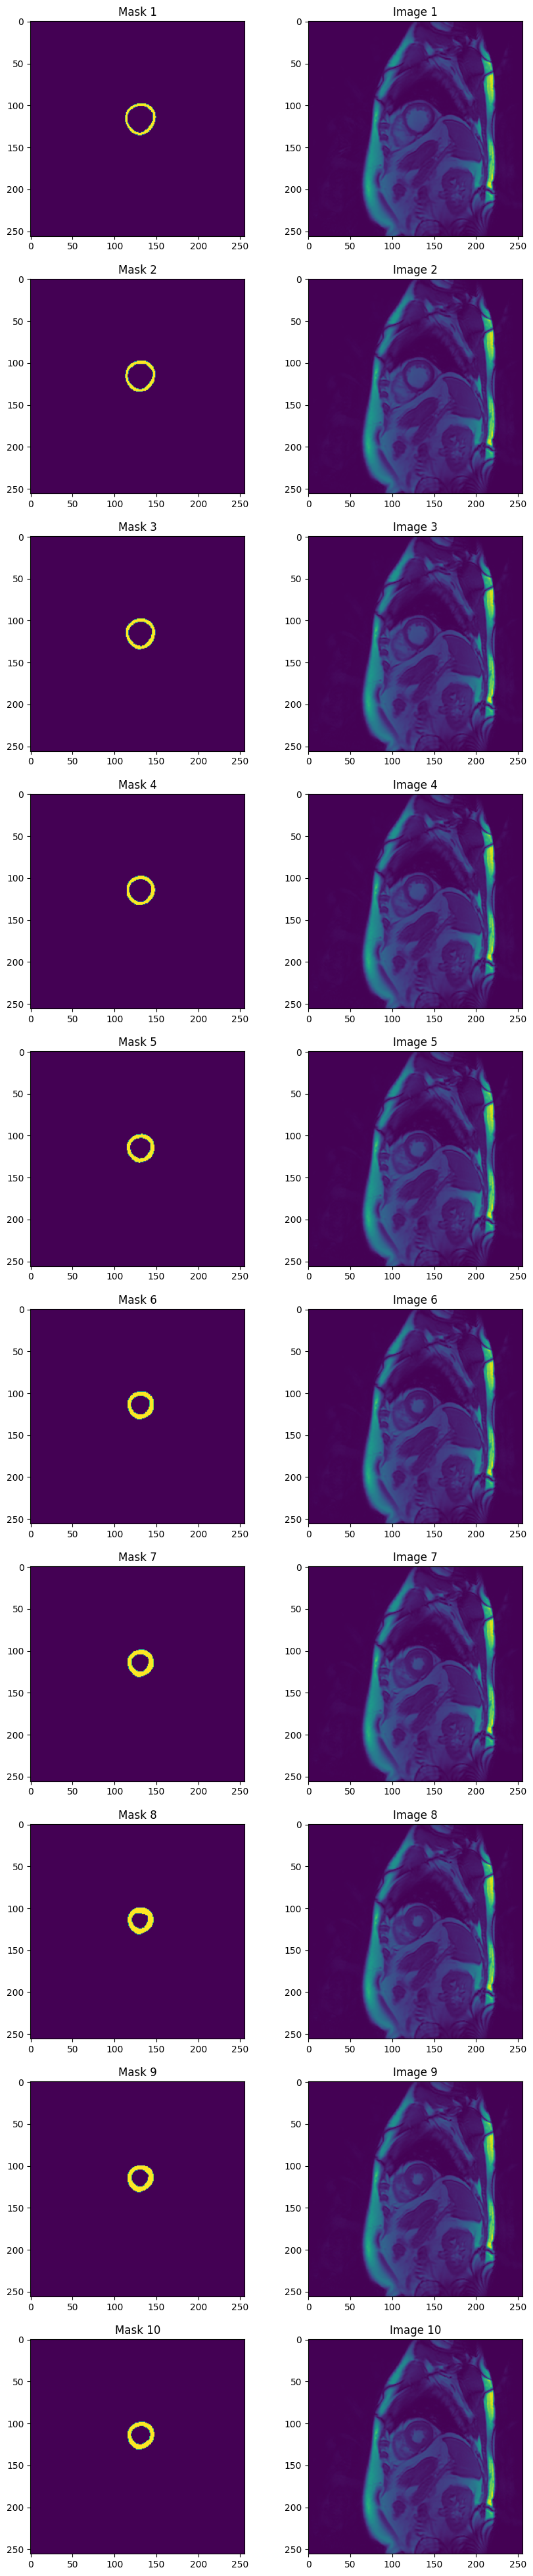

In [ ]:
import PIL
import PIL.Image

plt.figure(figsize=(10,50))

for i in range(10):
  img = PIL.Image.open(mask_files[i])
  mask = PIL.Image.open(image_files[i])

  plt.subplot(10, 2, i*2+1)
  plt.imshow(img)
  plt.title(f'Mask {i+1}')

  plt.subplot(10, 2, i*2+2)
  plt.imshow(mask)
  plt.title(f'Image {i+1}')

plt.show()

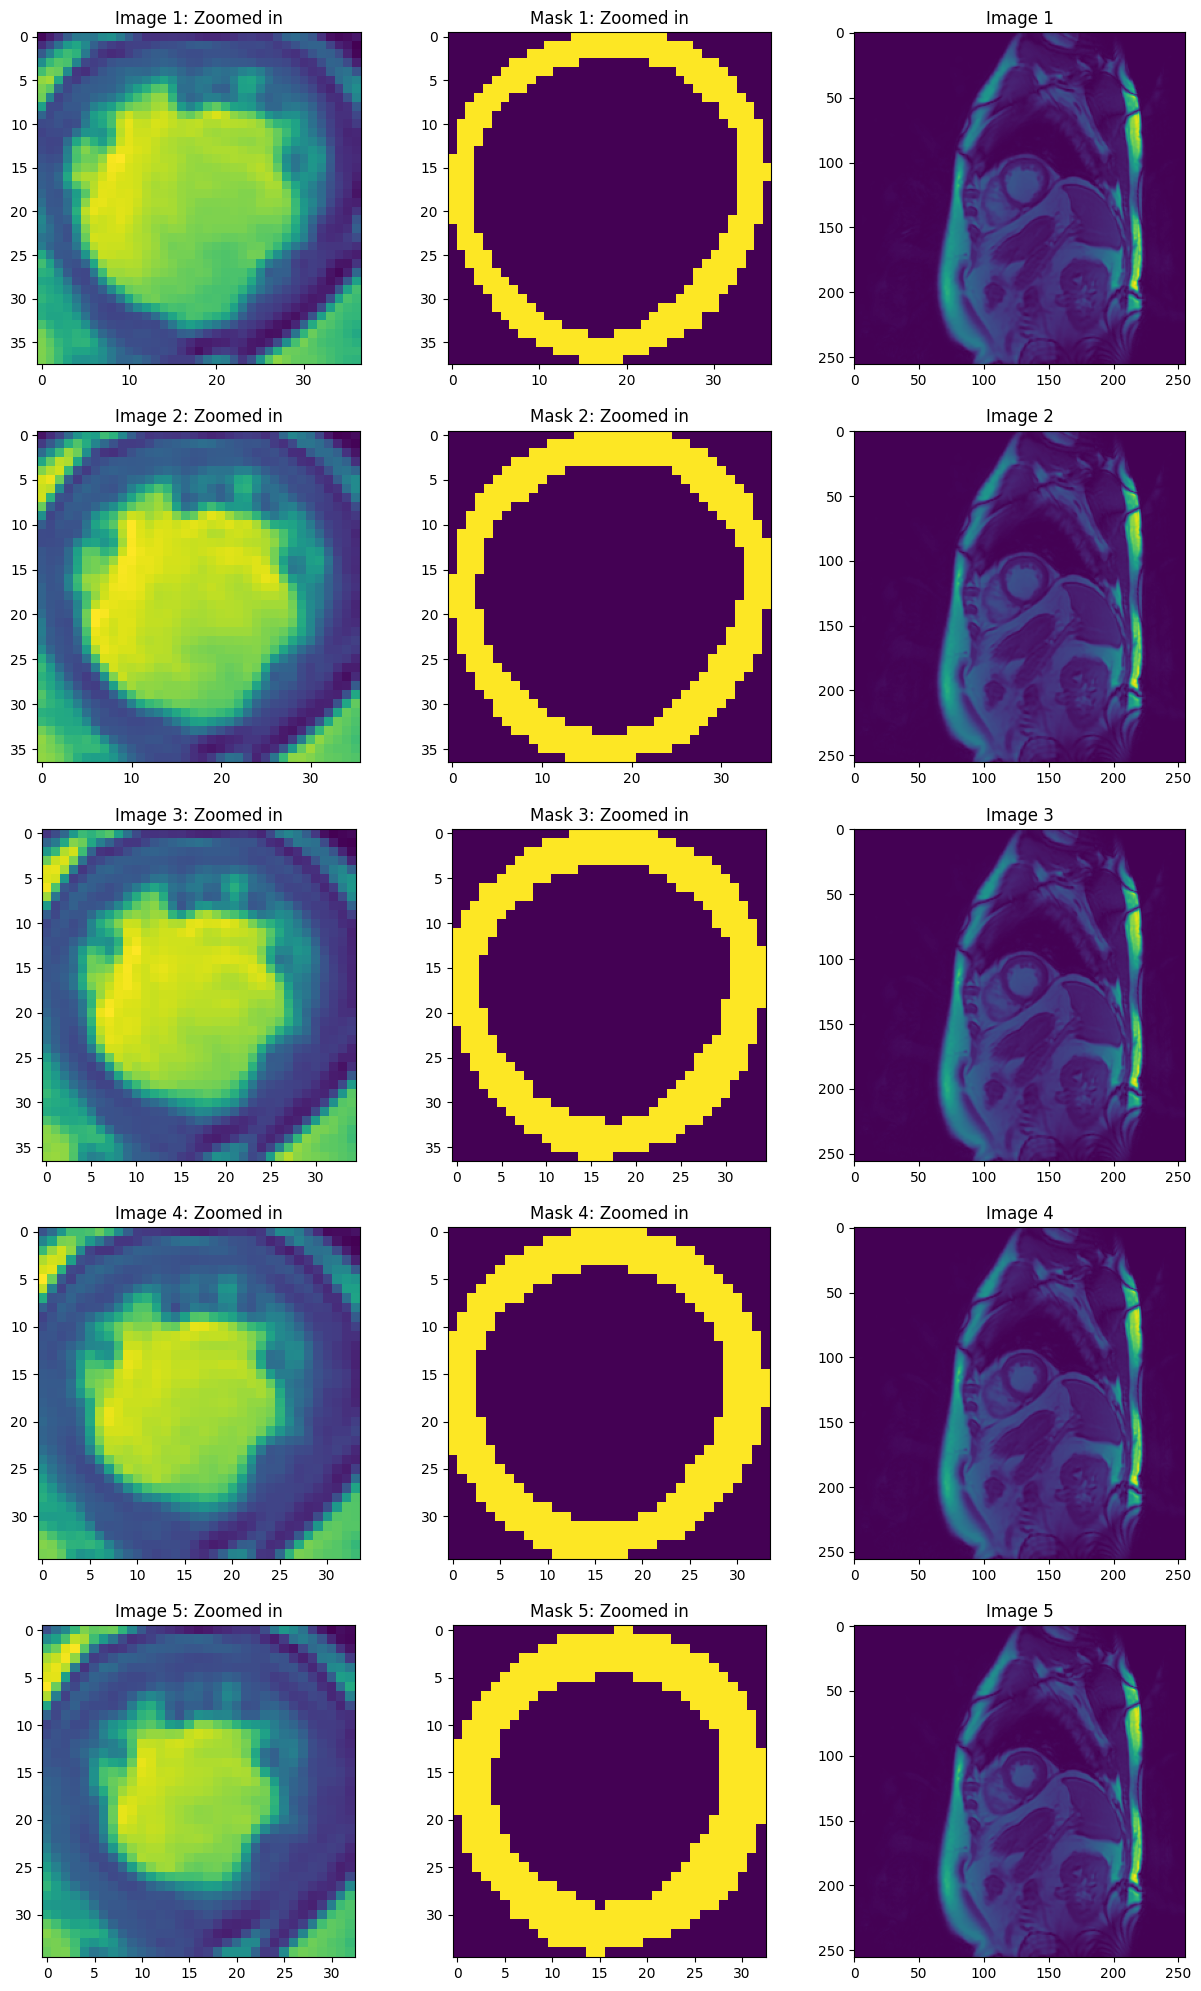

In [ ]:
N_rows = 5
N_cols = 3

plt.figure(figsize=(15,5*N_rows))

for i in range(N_rows):
  img = PIL.Image.open(image_files[i])
  mask = PIL.Image.open(mask_files[i])

  img_array = np.array(img)
  mask_array = np.array(mask)

  coordinates_255 = np.argwhere(mask_array == 255)

  # Find maximum and minimum x and y values
  max_x = np.max(coordinates_255[:, 0])
  min_x = np.min(coordinates_255[:, 0])
  max_y = np.max(coordinates_255[:, 1])
  min_y = np.min(coordinates_255[:, 1])

  new_img = img_array[min_x:max_x+1, min_y:max_y+1]
  new_mask = mask_array[min_x:max_x+1, min_y:max_y+1]

  plt.subplot(N_rows, N_cols, i*N_cols+1)
  plt.imshow(new_img)
  plt.title(f'Image {i+1}: Zoomed in')

  plt.subplot(N_rows, N_cols, i*N_cols+2)
  plt.imshow(new_mask)
  plt.title(f'Mask {i+1}: Zoomed in')

  plt.subplot(N_rows, N_cols, i*N_cols+3)
  plt.imshow(img_array)
  plt.title(f'Image {i+1}')

plt.show()

# 3D CNN Neural Network

# Imports

In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import imageio
import matplotlib.pyplot as plt

In [ ]:
print(tf.__version__)

2.15.0


# Preprocess data
### 1.   I'm cutting out the left ventricle from the orginal image using the mask and projecting it onto a 60x60 numpy array.
### 2.   I stack all the numpy arrays of a patient case into a (20,60,60) numpy array and save it.



In [ ]:
healthy_data_dir = '/content/drive/MyDrive/CMR Thesis/Healthy_final/'
Healthy_MyocardiumMasks = tf.data.Dataset.list_files((str(healthy_data_dir)+'*/*/*/MaskData/MyocardiumMasks'), shuffle=False)
Healthy_ImageData = tf.data.Dataset.list_files((str(healthy_data_dir)+'*/*/*/ImageData/'), shuffle=False)

icmp_data_dir = '/content/drive/MyDrive/CMR Thesis/ICMP_final/'
ICMP_MyocardiumMasks = tf.data.Dataset.list_files((str(icmp_data_dir)+'*/*/*/MaskData/MyocardiumMasks'), shuffle=False)
ICMP_ImageData = tf.data.Dataset.list_files((str(icmp_data_dir)+'*/*/*/ImageData/'), shuffle=False)

In [ ]:
def mask_squares_from_images(image_files,mask_files):

  new_imgs = []

  for i in range(len(image_files)):
    img = PIL.Image.open(image_files[i])
    mask = PIL.Image.open(mask_files[i])

    img_array = np.array(img)
    mask_array = np.array(mask)

    coordinates_255 = np.argwhere(mask_array == 255)

    # Find maximum and minimum x and y values
    max_x = np.max(coordinates_255[:, 0])
    min_x = np.min(coordinates_255[:, 0])
    max_y = np.max(coordinates_255[:, 1])
    min_y = np.min(coordinates_255[:, 1])

    new_img = img_array[min_x:max_x+1, min_y:max_y+1]

    target_size = (60, 60)
    padded_img = np.ones(target_size)
    padded_img[:new_img.shape[0], :new_img.shape[1]] = new_img

    new_imgs.append(padded_img)

  return np.array(new_imgs)

In [ ]:
def case_stack(f, g):
  masks_tf = tf.data.Dataset.list_files(str(f.numpy().decode('utf-8')+'/*'), shuffle = False)
  masks_arr = [z.numpy().decode('utf-8') for z in masks_tf]
  masks_arr.sort(key = my_digit_sort)

  images_tf = tf.data.Dataset.list_files(str(g.numpy().decode('utf-8')+'/*'), shuffle = False)
  images_arr = [z.numpy().decode('utf-8') for z in images_tf]
  images_arr.sort(key = my_digit_sort)
  new_imgs = mask_squares_from_images(images_arr, masks_arr)

  return np.stack(new_imgs)

In [ ]:
def save_stacks(masks_tf, images_tf, label):
  output_file_dir = '/content/drive/MyDrive/DL_CMR/'
  case_index = 1
  for f, g in zip(masks_tf, images_tf):
    output_file = output_file_dir + f'{label}/{case_index}.npy'
    # output_file = output_file_dir + f'{label}/{case_index}.gif'
    stack = case_stack(f,g)
    np.save(output_file, stack)
    # imageio.mimsave(output_file, stack)
    print(f'\rCompletion status: {case_index}/60', end='', flush=True)
    case_index += 1



In [ ]:
save_stacks(Healthy_MyocardiumMasks, Healthy_ImageData, 'Healthy')

Completion status: 60/60

In [ ]:
save_stacks(ICMP_MyocardiumMasks, ICMP_ImageData, 'ICMP')

Completion status: 60/60

# Load and Check Data and Batching Data

In [ ]:
def check_files(files):
  case_index = 1
  length  = len(files)
  for f in files:
    case_t = np.load(f.numpy().decode('utf-8'))
    if case_t.shape != (20,60,60):
      print('\n')
      print('----------------------------')
      print('File: ' +  f.numpy().decode('utf-8') + ' not (20,60,60)')
      print(f'Is instead: {case_t.shape}')
      print('----------------------------')
      print('\n')
    print(f'\rCompletion status: {case_index}/{length}', end='', flush=True)
    case_index +=1

In [ ]:
files = tf.data.Dataset.list_files('/content/drive/MyDrive/DL_CMR_NP/ICMP_NP/*', shuffle=False)
check_files(files)

files = tf.data.Dataset.list_files('/content/drive/MyDrive/DL_CMR_NP/Healthy_NP/*', shuffle=False)
check_files(files)

Completion status: 25/60

----------------------------
File: /content/drive/MyDrive/DL_CMR_NP/ICMP_NP/32.npy not (20,60,60)
Is instead: (21, 60, 60)
----------------------------


Completion status: 60/60

In [ ]:
def load_data_and_label(index):
    if index <= 60:
      data =  np.load(f'/content/drive/MyDrive/DL_CMR_NP/Healthy_NP/{index}.npy')
      label = 0
    else:
      index = index - 60
      data =  np.load(f'/content/drive/MyDrive/DL_CMR_NP/ICMP_NP/{index}.npy')
      label = 1

      if data.shape[0] > 20:
        data = data[0:20 :, :]

    return data/255, label

# Function to flip the data
def flip_data_left_right(data, label):
    # Flip along the vertical axis
    data = tf.convert_to_tensor(data)
    data = tf.image.flip_left_right(data)
    return data, label

def flip_data_up_down(data, label):
  data = tf.convert_to_tensor(data)
  data = tf.image.flip_up_down(data)
  return data, label

First 5 images of Healthy Case 1 and ICMP Case 1


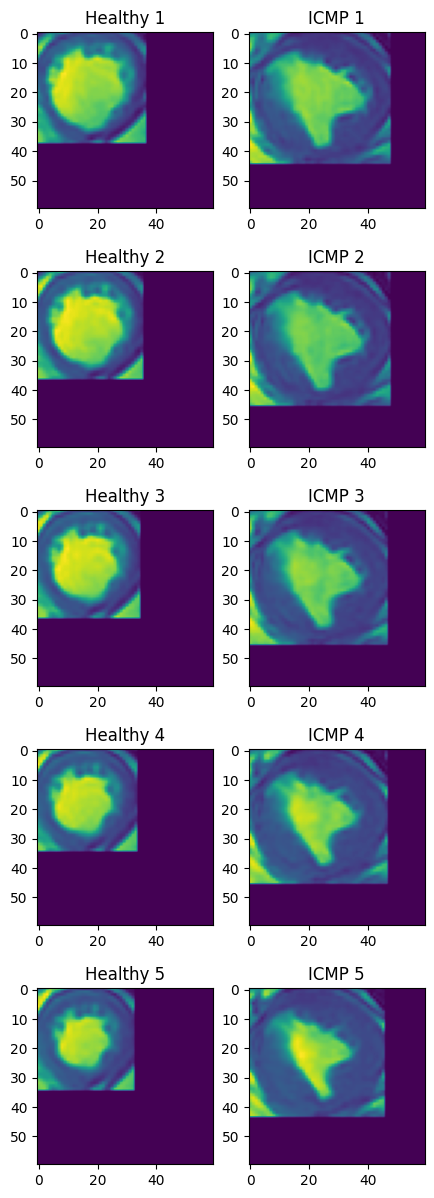

First 5 images of Healthy Case 2 and ICMP Case 2


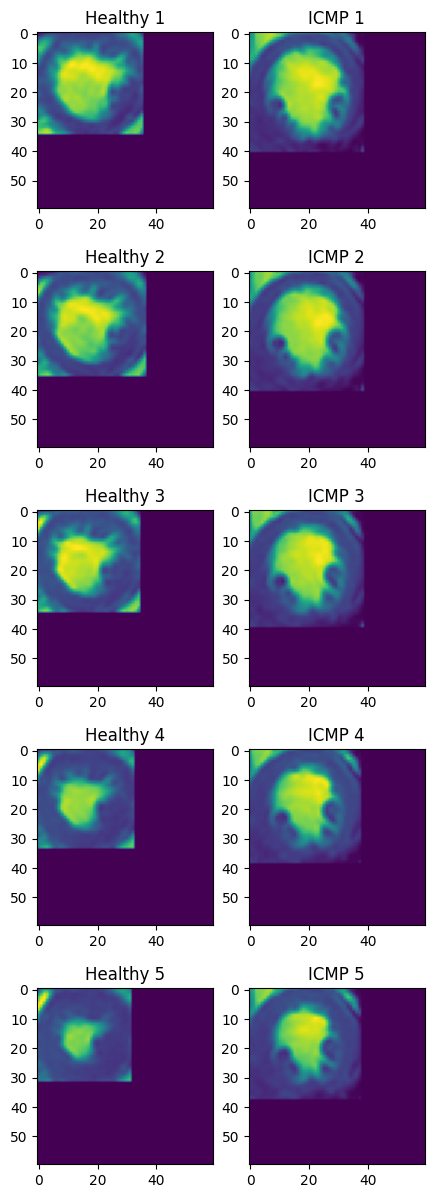

First 5 images of Healthy Case 3 and ICMP Case 3


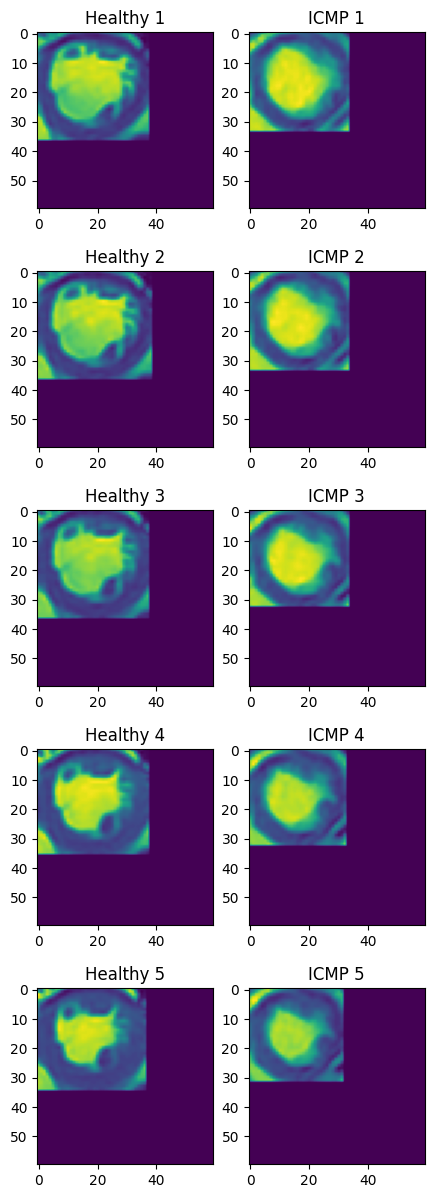

First 5 images of Healthy Case 4 and ICMP Case 4


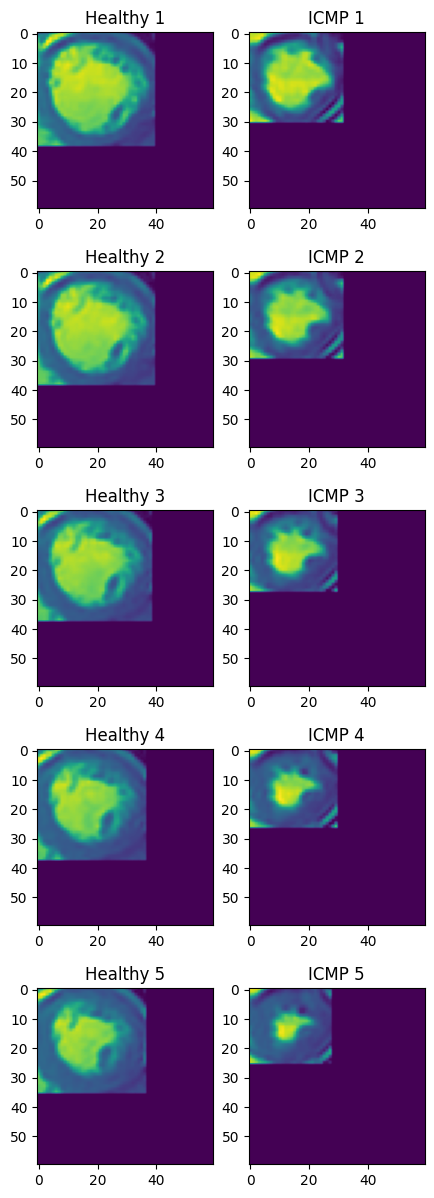

First 5 images of Healthy Case 5 and ICMP Case 5


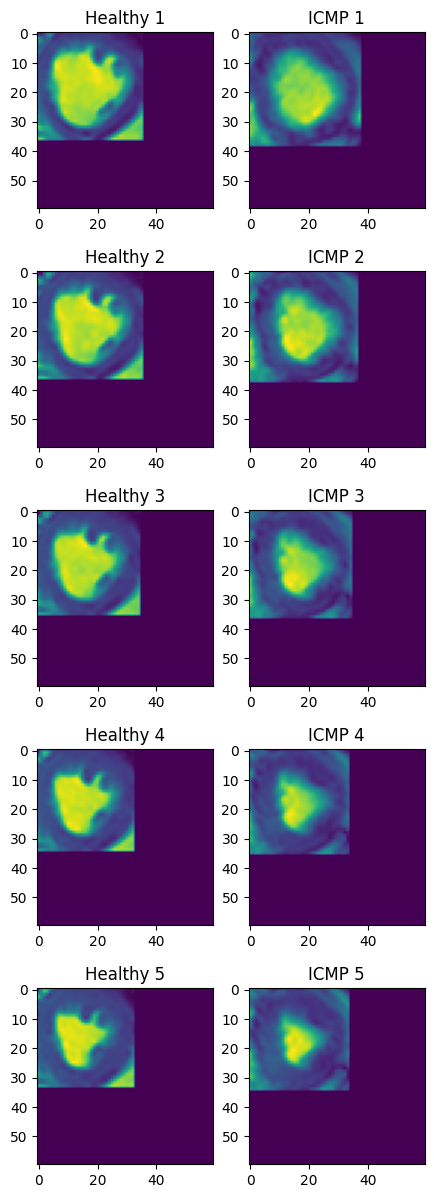

First 5 images of Healthy Case 6 and ICMP Case 6


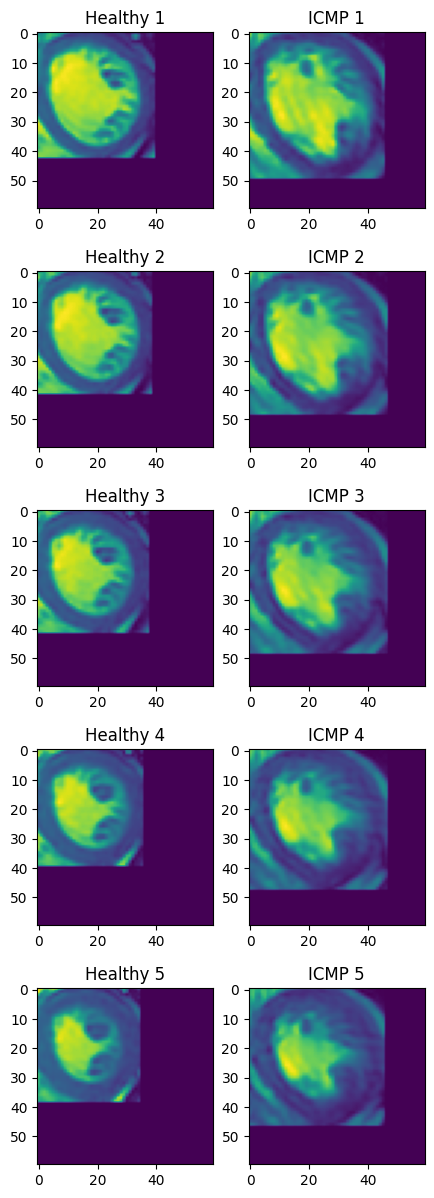

First 5 images of Healthy Case 7 and ICMP Case 7


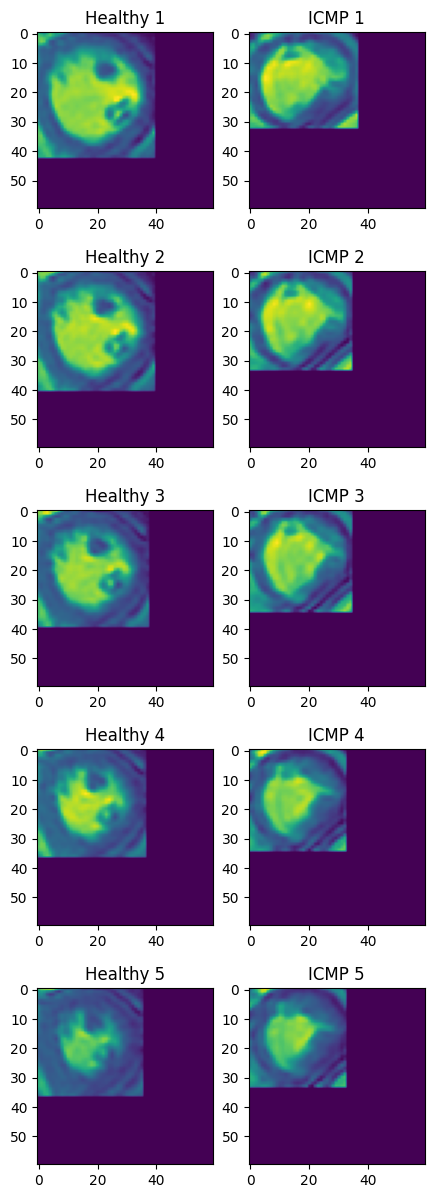

In [ ]:
for i in range(1, 8):

  print(f"First 5 images of Healthy Case {i} and ICMP Case {i}")

  data_healthy, label_healthy = load_data_and_label(i)
  data_icmp, label_icmp = load_data_and_label(60+i)

  plt.figure(figsize=(5,15))

  index = 0

  for image_h, image_icmp in zip(data_healthy[0:5], data_icmp[0:5]):

    plt.subplot(5, 2, index*2+1)
    plt.imshow(image_h)
    plt.title(f'Healthy {index+1}')
    plt.imshow(image_h)

    plt.subplot(5, 2, index*2+2)
    plt.imshow(image_icmp)
    plt.title(f'ICMP {index+1}')


    index += 1

  plt.show()

In [ ]:
num_samples = 121
indices = tf.data.Dataset.range(1, num_samples)
dataset = indices.map(lambda x: tf.numpy_function(load_data_and_label, [x], (tf.double, tf.int64)))

# Shuffle the dataset
dataset = dataset.shuffle(buffer_size=num_samples)  # Shuffle the dataset

# Define the split ratio
split_ratio = 0.6
val_ratio = 0.2

train_size = int(split_ratio * num_samples)
val_size = int(val_ratio * num_samples)
test_size = num_samples - train_size - val_size

# Split the dataset into train and test datasets
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size).take(val_size)
test_dataset = dataset.skip(train_size + val_size)

train_dataset_size = tf.data.experimental.cardinality(train_dataset).numpy()
print("Size of initial train dataset:", train_dataset_size)
train_dataset = train_dataset.concatenate(train_dataset.map(flip_data_left_right).take(train_dataset_size))

train_dataset_size = tf.data.experimental.cardinality(train_dataset).numpy()
train_dataset = train_dataset.concatenate(train_dataset.map(flip_data_up_down).take(train_dataset_size))

train_dataset_size = tf.data.experimental.cardinality(train_dataset).numpy()
val_dataset_size = tf.data.experimental.cardinality(val_dataset).numpy()
test_dataset_size = tf.data.experimental.cardinality(test_dataset).numpy()


print("Size of augmented train dataset:", train_dataset_size)
print("Size of train dataset:", val_dataset_size)
print("Size of train dataset:", test_dataset_size)

Size of initial train dataset: 72
Size of augmented train dataset: 288
Size of train dataset: 24
Size of train dataset: 24


## TESTING FOR DATA LEAK

In [ ]:
loop = 0
for tr_arr in train_dataset:
  val = 0
  for val_arr in val_dataset:
    print(f'\rLoop {loop}/{train_dataset_size} tst: {val}/{24}', end='', flush=True)
    if np.array_equal(tr_arr, val_arr):
      print("LEAK!!!")
      break
    val+=1
  loop+=1

In [ ]:
loop = 0
for tr_arr in train_dataset:
  val = 0
  for tst_arr in test_dataset:
    print(f'\rLoop {loop}/{train_dataset_size} val: {val}/{24}', end='', flush=True)
    if np.array_equal(tr_arr, tst_arr):
      print("LEAK!!!")
      break
    val+=1
  loop+=1

In [ ]:
loop = 0
for val_arr in val_dataset:
  val = 0
  for tst_arr in test_dataset:
    print(f'\rLoop {loop}/{val_dataset_size} tst: {val}/{24}', end='', flush=True)
    if np.array_equal(tr_arr, tst_arr):
      print("LEAK!!!")
      break
    val+=1
  loop+=1

## Batching

In [ ]:
# Batch the datasets
batch_size = 8 # 8, 16, 32
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

In [ ]:
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Now you can iterate over the dataset in your training loop
for batch_data, batch_labels in train_dataset:
  print(batch_data.shape)
  print(batch_labels)

(8, 20, 60, 60)
tf.Tensor([0 1 0 1 0 0 0 0], shape=(8,), dtype=int64)
(8, 20, 60, 60)
tf.Tensor([0 1 1 0 1 0 1 0], shape=(8,), dtype=int64)
(8, 20, 60, 60)
tf.Tensor([0 0 1 1 0 0 0 1], shape=(8,), dtype=int64)
(8, 20, 60, 60)
tf.Tensor([0 1 1 0 1 0 1 0], shape=(8,), dtype=int64)
(8, 20, 60, 60)
tf.Tensor([0 1 1 1 0 1 1 0], shape=(8,), dtype=int64)
(8, 20, 60, 60)
tf.Tensor([0 1 0 0 1 0 1 1], shape=(8,), dtype=int64)
(8, 20, 60, 60)
tf.Tensor([0 1 0 1 1 0 0 1], shape=(8,), dtype=int64)
(8, 20, 60, 60)
tf.Tensor([1 1 0 1 0 0 0 1], shape=(8,), dtype=int64)
(8, 20, 60, 60)
tf.Tensor([0 0 0 0 1 0 1 0], shape=(8,), dtype=int64)
(8, 20, 60, 60)
tf.Tensor([1 0 0 0 0 1 1 1], shape=(8,), dtype=int64)
(8, 20, 60, 60)
tf.Tensor([1 0 1 1 1 1 1 0], shape=(8,), dtype=int64)
(8, 20, 60, 60)
tf.Tensor([0 1 0 0 0 0 1 0], shape=(8,), dtype=int64)
(8, 20, 60, 60)
tf.Tensor([0 1 0 1 1 0 0 0], shape=(8,), dtype=int64)
(8, 20, 60, 60)
tf.Tensor([1 0 1 0 1 1 1 0], shape=(8,), dtype=int64)
(8, 20, 60, 60)
tf.T

In [ ]:
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Now you can iterate over the dataset in your training loop
for batch_data, batch_labels in test_dataset:
  print(batch_data.shape)
  print(batch_labels)

(8, 20, 60, 60)
tf.Tensor([1 0 0 1 1 1 0 0], shape=(8,), dtype=int64)
(8, 20, 60, 60)
tf.Tensor([1 1 0 0 0 0 1 1], shape=(8,), dtype=int64)
(8, 20, 60, 60)
tf.Tensor([1 0 1 0 0 1 1 0], shape=(8,), dtype=int64)


In [ ]:
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Now you can iterate over the dataset in your training loop
for batch_data, batch_labels in val_dataset:
  print(batch_data.shape)
  print(batch_labels)

(8, 20, 60, 60)
tf.Tensor([1 1 1 1 1 0 1 0], shape=(8,), dtype=int64)
(8, 20, 60, 60)
tf.Tensor([0 1 1 0 0 0 0 0], shape=(8,), dtype=int64)
(8, 20, 60, 60)
tf.Tensor([1 1 0 0 1 0 0 0], shape=(8,), dtype=int64)


# Model and Single Run

In [ ]:
# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', input_shape=(20, 60, 60, 1)),
    tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
    tf.keras.layers.Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu', padding = 'same'),
    tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
    tf.keras.layers.Conv3D(filters=128, kernel_size=(3, 3, 3), activation='relu'),
    tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary output
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Binary cross-entropy loss for binary classification
              metrics=['accuracy'],
              run_eagerly=True)

# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 18, 58, 58, 32)    896       
                                                                 
 max_pooling3d (MaxPooling3  (None, 9, 29, 29, 32)     0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 9, 29, 29, 64)     55360     
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 4, 14, 14, 64)     0         
 g3D)                                                            
                                                                 
 conv3d_2 (Conv3D)           (None, 2, 12, 12, 128)    221312    
                                                                 
 max_pooling3d_2 (MaxPoolin  (None, 1, 6, 6, 128)      0

In [ ]:
train_dataset = train_dataset.map(lambda x, y: (tf.reshape(x, [-1, 20, 60, 60, 1]), y))
test_dataset = test_dataset.map(lambda x, y: (tf.reshape(x, [-1, 20, 60, 60, 1]), y))
val_dataset = val_dataset.map(lambda x, y: (tf.reshape(x, [-1, 20, 60, 60, 1]), y))

In [ ]:
# Define number of epochs
epochs = 10

# Define EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor
    patience=3,  # Number of epochs with no improvement
    restore_best_weights=True  # Restore model weights to the best observed during training
)

history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)


# Fit the model
# model.fit(train_dataset, epochs=epochs)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
36/36 [==============================] - 112s 3s/step - loss: 2.0892 - accuracy: 0.7014 - val_loss: 0.4721 - val_accuracy: 0.7500
Epoch 2/10
36/36 [==============================] - 121s 3s/step - loss: 0.4079 - accuracy: 0.8472 - val_loss: 0.3568 - val_accuracy: 0.8750
Epoch 3/10
36/36 [==============================] - 122s 3s/step - loss: 0.4219 - accuracy: 0.8333 - val_loss: 0.4959 - val_accuracy: 0.7500
Epoch 4/10
36/36 [==============================] - 117s 3s/step - loss: 0.3424 - accuracy: 0.8576 - val_loss: 0.2327 - val_accuracy: 0.9583
Epoch 5/10
36/36 [==============================] - 118s 3s/step - loss: 0.2328 - accuracy: 0.9340 - val_loss: 0.7542 - val_accuracy: 0.7917
Epoch 6/10
36/36 [==============================] - 116s 3s/step - loss: 0.2779 - accuracy: 0.9028 - val_loss: 0.1918 - val_accuracy: 0.9583
Epoch 7/10
3/3 [==============================] - 3s 604ms/step - loss: 0.2475 - accuracy: 0.9583
Test Loss: 0.24754732847213745
Test Accuracy: 0.95833331

In [ ]:
model.save_weights('/content/drive/MyDrive/DL_CMR_WEIGHTS/model_weights_batch_size_8_split_60_20_20.h5')

# Cross Validation

## Try 1

In [ ]:
def create_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', input_shape=(20, 60, 60, 1)),
    tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
    tf.keras.layers.Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu', padding = 'same'),
    tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
    tf.keras.layers.Conv3D(filters=128, kernel_size=(3, 3, 3), activation='relu'),
    tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary output
    ])

  model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Binary cross-entropy loss for binary classification
              metrics=['accuracy'],
              run_eagerly=True)

  return model


def load_data_and_label(index):
    if index <= 60:
      data =  np.load(f'/content/drive/MyDrive/DL_CMR_NP/Healthy_NP/{index}.npy')
      label = 0
    else:
      index = index - 60
      data =  np.load(f'/content/drive/MyDrive/DL_CMR_NP/ICMP_NP/{index}.npy')
      label = 1

      if data.shape[0] > 20:
        data = data[0:20 :, :]

    return data/255, label

# Function to flip the data
def flip_data_left_right(data, label):
    # Flip along the vertical axis
    data = tf.convert_to_tensor(data)
    data = tf.image.flip_left_right(data)
    return data, label

def flip_data_up_down(data, label):
  data = tf.convert_to_tensor(data)
  data = tf.image.flip_up_down(data)
  return data, label



num_samples = 121
indices = tf.data.Dataset.range(1, num_samples)
dataset = indices.map(lambda x: tf.numpy_function(load_data_and_label, [x], (tf.double, tf.int64)))

# Shuffle the dataset
dataset = dataset.shuffle(buffer_size=num_samples)  # Shuffle the dataset

def split_dataset(dataset, num_parts):
    # Determine the size of each part
    dataset_size = dataset.cardinality().numpy()
    part_size = dataset_size // num_parts

    # Split the dataset into parts
    parts = []
    for i in range(num_parts):
        start = i * part_size
        end = (i + 1) * part_size if i < num_parts - 1 else None
        part = dataset.skip(start).take(part_size)
        parts.append(part)

    return parts


# Split dataset into 5 parts
parts = split_dataset(dataset, 5)
batch_size = 16 # 8, 16, 32
epochs = 10

accuracies = []

early_stopping = tf.keras.callbacks.EarlyStopping(
    # monitor='val_accuracy',  # Metric to monitor
    monitor='val_loss',
    patience=5,  # Number of epochs with no improvement
    restore_best_weights=True  # Restore model weights to the best observed during training
)

# Concatenate 3 different parts together, repeat 5 times
for i in range(5):
    print(f"LOOP {i+1}")
    train_dataset = parts[i%5].concatenate(parts[(i+1)%5].concatenate(parts[(i+2)%5]))

    # Assign the remaining two parts to testing and validation sets
    test_dataset = parts[(i+3)%5]
    val_dataset = parts[(i+4)%5]

    # Augment train data
    train_dataset_size = tf.data.experimental.cardinality(train_dataset).numpy()
    train_dataset = train_dataset.concatenate(train_dataset.map(flip_data_left_right).take(train_dataset_size))
    train_dataset_size = tf.data.experimental.cardinality(train_dataset).numpy()
    train_dataset = train_dataset.concatenate(train_dataset.map(flip_data_up_down).take(train_dataset_size))

    train_dataset = train_dataset.batch(batch_size)
    test_dataset = test_dataset.batch(batch_size)
    val_dataset = val_dataset.batch(batch_size)

    train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    train_dataset = train_dataset.map(lambda x, y: (tf.reshape(x, [-1, 20, 60, 60, 1]), y))
    test_dataset = test_dataset.map(lambda x, y: (tf.reshape(x, [-1, 20, 60, 60, 1]), y))
    val_dataset = val_dataset.map(lambda x, y: (tf.reshape(x, [-1, 20, 60, 60, 1]), y))

    model = create_model()

    history = model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=val_dataset,
        callbacks=[early_stopping]
    )

    test_loss, test_accuracy = model.evaluate(test_dataset)

    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)

    accuracies.append(test_accuracy)


print("All acc: ", accuracies)
print("Average acc:", np.mean(accuracies))

LOOP 1
Epoch 1/10


18/18 [==============================] - 125s 324ms/step - loss: 0.5442 - accuracy: 0.7326 - val_loss: 0.5593 - val_accuracy: 0.8333
Epoch 2/10
18/18 [==============================] - 7s 359ms/step - loss: 0.6648 - accuracy: 0.7500 - val_loss: 0.5739 - val_accuracy: 0.9167
Epoch 3/10
18/18 [==============================] - 8s 410ms/step - loss: 0.4775 - accuracy: 0.8333 - val_loss: 0.4269 - val_accuracy: 0.8333
Epoch 4/10
18/18 [==============================] - 7s 376ms/step - loss: 0.3984 - accuracy: 0.8681 - val_loss: 0.4576 - val_accuracy: 0.7917
Epoch 5/10
18/18 [==============================] - 7s 377ms/step - loss: 0.3432 - accuracy: 0.8750 - val_loss: 0.2588 - val_accuracy: 0.8750
Epoch 6/10
18/18 [==============================] - 7s 407ms/step - loss: 0.3276 - accuracy: 0.8785 - val_loss: 0.9257 - val_accuracy: 0.6667
Epoch 7/10
18/18 [==============================] - 7s 367ms/step - loss: 0.4145 - accuracy: 0.8472 - val_loss: 0.5731 - val_accuracy: 0.7500
Epoch 8/10
18/1

## INSANE Try 2 !!

In [ ]:
def create_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', input_shape=(20, 60, 60, 1)),
    tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
    tf.keras.layers.Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu', padding = 'same'),
    tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
    tf.keras.layers.Conv3D(filters=128, kernel_size=(3, 3, 3), activation='relu'),
    tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary output
    ])

  model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Binary cross-entropy loss for binary classification
              metrics=['accuracy'],
              run_eagerly=True)

  return model


def load_data_and_label(index):
    if index <= 60:
      data =  np.load(f'/content/drive/MyDrive/DL_CMR_NP/Healthy_NP/{index}.npy')
      label = 0
    else:
      index = index - 60
      data =  np.load(f'/content/drive/MyDrive/DL_CMR_NP/ICMP_NP/{index}.npy')
      label = 1

      if data.shape[0] > 20:
        data = data[0:20 :, :]

    return data/255, label

# Function to flip the data
def flip_data_left_right(data, label):
    # Flip along the vertical axis
    data = tf.convert_to_tensor(data)
    data = tf.image.flip_left_right(data)
    return data, label

def flip_data_up_down(data, label):
  data = tf.convert_to_tensor(data)
  data = tf.image.flip_up_down(data)
  return data, label



num_samples = 121
indices = tf.data.Dataset.range(1, num_samples)
dataset = indices.map(lambda x: tf.numpy_function(load_data_and_label, [x], (tf.double, tf.int64)))

# Shuffle the dataset
dataset = dataset.shuffle(buffer_size=num_samples)  # Shuffle the dataset

def split_dataset(dataset, num_parts):
    # Determine the size of each part
    dataset_size = dataset.cardinality().numpy()
    part_size = dataset_size // num_parts

    # Split the dataset into parts
    parts = []
    for i in range(num_parts):
        start = i * part_size
        end = (i + 1) * part_size if i < num_parts - 1 else None
        part = dataset.skip(start).take(part_size)
        parts.append(part)

    return parts


# Split dataset into 5 parts
parts = split_dataset(dataset, 5)
batch_size = 16 # 8, 16, 32
epochs = 30

accuracies = []

early_stopping = tf.keras.callbacks.EarlyStopping(
    # monitor='val_accuracy',  # Metric to monitor
    monitor='val_loss',
    patience=10,  # Number of epochs with no improvement
    restore_best_weights=True  # Restore model weights to the best observed during training
)

# Concatenate 3 different parts together, repeat 5 times
for i in range(5):
    print(f"LOOP {i+1}")
    train_dataset = parts[i%5].concatenate(parts[(i+1)%5].concatenate(parts[(i+2)%5]))

    # Assign the remaining two parts to testing and validation sets
    test_dataset = parts[(i+3)%5]
    val_dataset = parts[(i+4)%5]

    # Augment train data
    train_dataset_size = tf.data.experimental.cardinality(train_dataset).numpy()
    train_dataset = train_dataset.concatenate(train_dataset.map(flip_data_left_right).take(train_dataset_size))
    train_dataset_size = tf.data.experimental.cardinality(train_dataset).numpy()
    train_dataset = train_dataset.concatenate(train_dataset.map(flip_data_up_down).take(train_dataset_size))

    train_dataset = train_dataset.batch(batch_size)
    test_dataset = test_dataset.batch(batch_size)
    val_dataset = val_dataset.batch(batch_size)

    train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    train_dataset = train_dataset.map(lambda x, y: (tf.reshape(x, [-1, 20, 60, 60, 1]), y))
    test_dataset = test_dataset.map(lambda x, y: (tf.reshape(x, [-1, 20, 60, 60, 1]), y))
    val_dataset = val_dataset.map(lambda x, y: (tf.reshape(x, [-1, 20, 60, 60, 1]), y))

    model = create_model()

    history = model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=val_dataset,
        callbacks=[early_stopping]
    )

    test_loss, test_accuracy = model.evaluate(test_dataset)

    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)

    accuracies.append(test_accuracy)


print("All acc: ", accuracies)
print("Average acc:", np.mean(accuracies))

LOOP 1
Epoch 1/30
18/18 [==============================] - 42s 2s/step - loss: 0.6781 - accuracy: 0.6146 - val_loss: 0.6851 - val_accuracy: 0.6250
Epoch 2/30
18/18 [==============================] - 9s 512ms/step - loss: 0.4572 - accuracy: 0.8542 - val_loss: 0.5068 - val_accuracy: 0.7500
Epoch 3/30
18/18 [==============================] - 7s 367ms/step - loss: 0.4593 - accuracy: 0.8125 - val_loss: 0.5137 - val_accuracy: 0.8333
Epoch 4/30
18/18 [==============================] - 7s 407ms/step - loss: 0.4033 - accuracy: 0.8646 - val_loss: 0.3675 - val_accuracy: 0.8750
Epoch 5/30
18/18 [==============================] - 7s 372ms/step - loss: 0.4833 - accuracy: 0.7778 - val_loss: 0.3348 - val_accuracy: 0.9167
Epoch 6/30
18/18 [==============================] - 7s 385ms/step - loss: 0.2935 - accuracy: 0.8854 - val_loss: 0.4039 - val_accuracy: 0.8333
Epoch 7/30
18/18 [==============================] - 7s 403ms/step - loss: 0.3667 - accuracy: 0.8507 - val_loss: 0.2538 - val_accuracy: 0.9167
E